In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
from sklearn.metrics import classification_report


# Import Preprocessed Dataset

In [23]:
spark = SparkSession.builder.appName('NeuralNetwork').getOrCreate()
df = spark.read.csv('/home/emiliano/Desktop/Università/Distributed Data Analysis/preprocessedData_SI.csv', header=True, inferSchema=True)

# Undersampling and Reporting Function


In [24]:
# Create undersampling function
def undersample_majority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(F.col('label')==1).count()
    whole_count = df.count()
    undersampled_majority = df.filter(F.col('label')==0) \
        .sample(withReplacement=False, fraction=(ratio*minority_count/whole_count),seed=88)
    undersampled_df = df.filter(F.col('label')==1).union(undersampled_majority)

    return undersampled_df

In [25]:
def print_classification_report(prediction):
    y_true = prediction.select("label")
    y_true = y_true.toPandas()
    y_pred = prediction.select("prediction")
    y_pred = y_pred.toPandas()
    print(classification_report(y_true, y_pred))

# Preparing the dataset


In [26]:
#Rename target_bool column to label
df_transformed = df.withColumnRenamed("fraud_bool", "label")
# Get a list of the columns in the dataset
columns = df_transformed.columns

# Remove the target column from the list
columns.remove("label")
assembler = VectorAssembler(inputCols=columns, outputCol='features')
data_transformed = assembler.transform(df_transformed)
# Prepare the final dataset
dataset = data_transformed.select('features', 'label')  # Ensure you have 'features' and 'label' columns

train, test = dataset.randomSplit([0.8, 0.2], seed=42)


# Baseline Model


In [12]:

layers = [30, 10, 5, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=256, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.9888687096484488


In [13]:
# print classification report for both classes 0 and 1
from sklearn.metrics import classification_report
y_true = result.select("label")
y_true = y_true.toPandas()
y_pred = result.select("prediction")
y_pred = y_pred.toPandas()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    198205
         1.0       0.29      0.00      0.01      2221

    accuracy                           0.99    200426
   macro avg       0.64      0.50      0.50    200426
weighted avg       0.98      0.99      0.98    200426



# GridSearch CV for MLP


In [33]:

layers = [30, 16, 8, 5, 2]

# Calculate total parameters
total_params = sum(layers[i] * layers[i + 1] + layers[i + 1] for i in range(len(layers) - 1))

# Generate random initial weights
initial_weights = np.random.uniform(-1, 1, total_params)

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=256, seed=1234, initialWeights=initial_weights.tolist())

# create the evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(trainer.blockSize, [128, 256, 512]) \
    .addGrid(trainer.maxIter, [100, 200, 300, 400]) \
    .addGrid(trainer.solver, ['gd', 'l-bfgs']) \
    .build()


# create the cross-validator
crossval = CrossValidator(estimator=trainer,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_undersampled)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)

24/12/04 20:50:48 WARN BlockManager: Asked to remove block broadcast_114462, which does not exist


# Best Parameters

In [34]:
best_model = cvModel.bestModel
print('Best Param (BlockSize): ', best_model._java_obj.getBlockSize())
print('Best Param (MaxIter): ', best_model._java_obj.getMaxIter())
print('Best Param (Solver): ', best_model._java_obj.getSolver())

Best Param (BlockSize):  128
Best Param (MaxIter):  400
Best Param (Solver):  l-bfgs


# Training on undersampled data with Best Parameters

In [27]:
# specify layers for the neural network:
layers = [30, 16, 8, 5, 2]

train_undersampled_ratio_2 = undersample_majority(train, ratio=2)
# Calculate total parameters
total_params = sum(layers[i] * layers[i + 1] + layers[i + 1] for i in range(len(layers) - 1))

# Generate random initial weights
initial_weights = np.random.uniform(-1, 1, total_params)

# create the trainer and set its parameters
trainer_for_accuracy = MultilayerPerceptronClassifier(maxIter=400, layers=layers, blockSize=128, seed=1234, initialWeights=initial_weights.tolist(), solver='l-bfgs')
model_acc = trainer_for_accuracy.fit(train_undersampled_ratio_2)
prediction = model_acc.transform(test)
print_classification_report(prediction)


              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94    198205
         1.0       0.06      0.67      0.11      2221

    accuracy                           0.88    200426
   macro avg       0.53      0.78      0.52    200426
weighted avg       0.99      0.88      0.93    200426



In [28]:
layers = [30, 16, 8, 5, 2]

train_undersampled_ratio_1 = undersample_majority(train, ratio=1)
# Calculate total parameters
total_params = sum(layers[i] * layers[i + 1] + layers[i + 1] for i in range(len(layers) - 1))

# Generate random initial weights
initial_weights = np.random.uniform(-1, 1, total_params)

# create the trainer and set its parameters
trainer_for_accuracy = MultilayerPerceptronClassifier(maxIter=400, layers=layers, blockSize=128, seed=1234, initialWeights=initial_weights.tolist(), solver='l-bfgs')
model_acc = trainer_for_accuracy.fit(train_undersampled_ratio_1)
prediction = model_acc.transform(test)
print_classification_report(prediction)

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89    198205
         1.0       0.04      0.78      0.08      2221

    accuracy                           0.81    200426
   macro avg       0.52      0.79      0.49    200426
weighted avg       0.99      0.81      0.88    200426



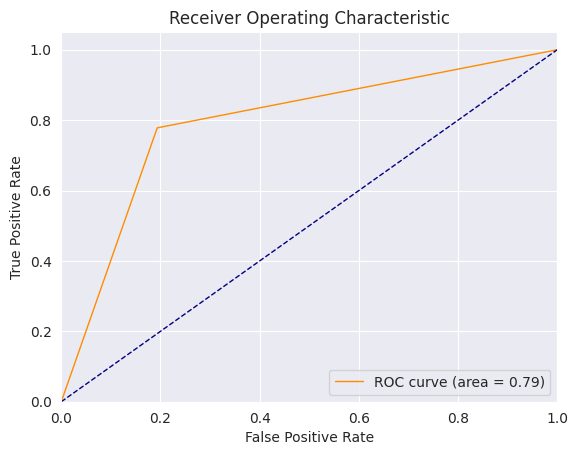

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

y_true = prediction.select("label")
y_true = y_true.toPandas()
y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
